# Example mPDF refinement for MnO

In [1]:
from __future__ import print_function
%matplotlib notebook

### Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from diffpy.mpdf import *
from diffpy.structure import loadStructure
from diffpy.utils.parsers import loadData

### Load in the atomic PDF fit (the residual will serve as the mPDF data).

<IPython.core.display.Javascript object>


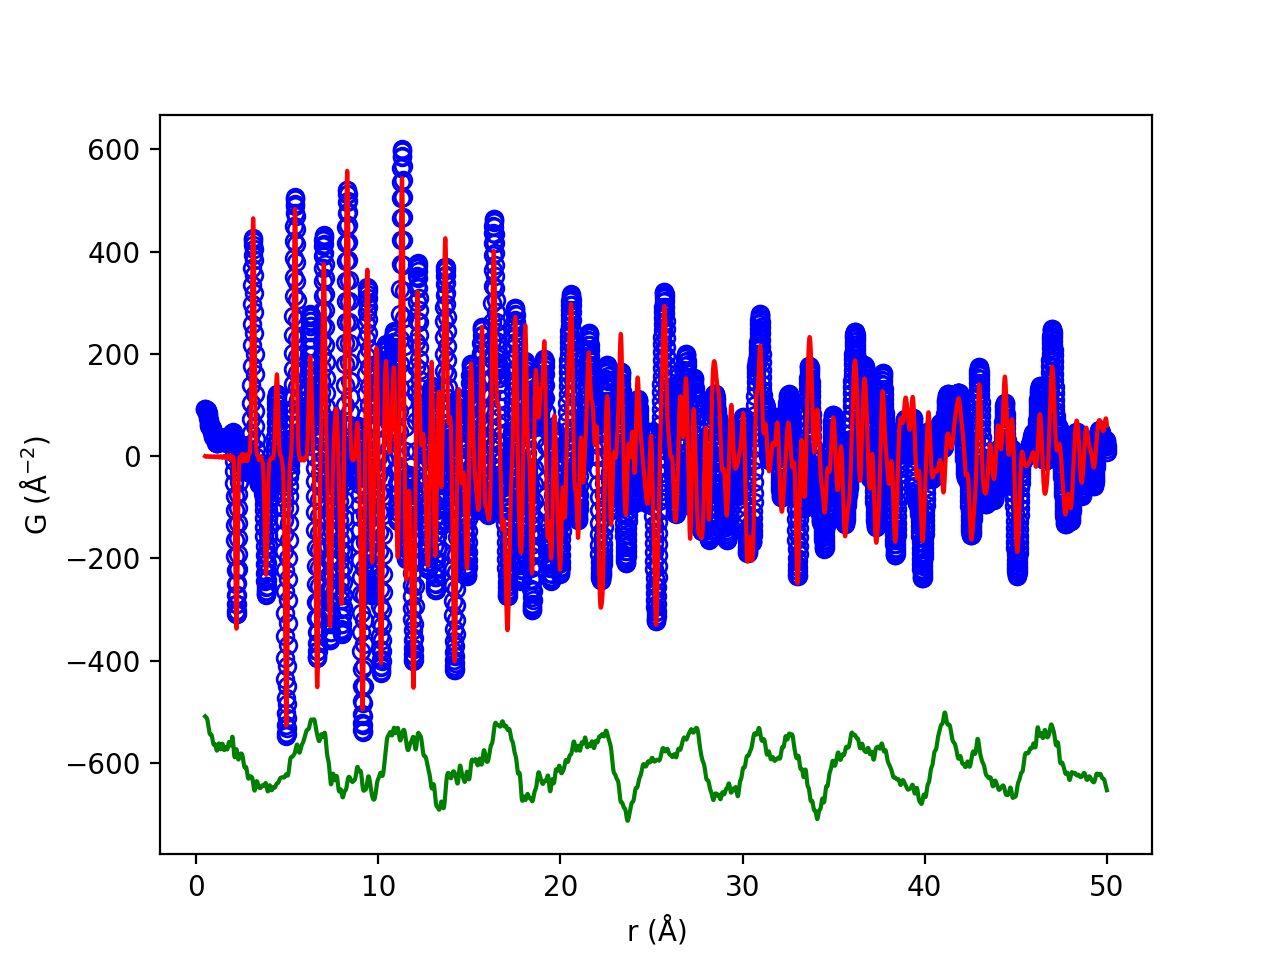

In [2]:
r, Gcalc, Gdiff = loadData('MnOfit_PDFgui.fgr', unpack=True, usecols=[0, 1, 3])
G = Gcalc + Gdiff

### Plot the fit
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r'r ($\mathdefault{\AA}$)')
ax.set_ylabel(r'G ($\mathdefault{\AA^{-2}}$)')

ax.plot(r, G, marker='o',mec='b',mfc='None',linestyle='None')
ax.plot(r, Gcalc, 'r-')
ax.plot(r, Gdiff + 1.1*G.min(),'g-');

### Generate the magnetic structure from the refined atomic structure

<IPython.core.display.Javascript object>


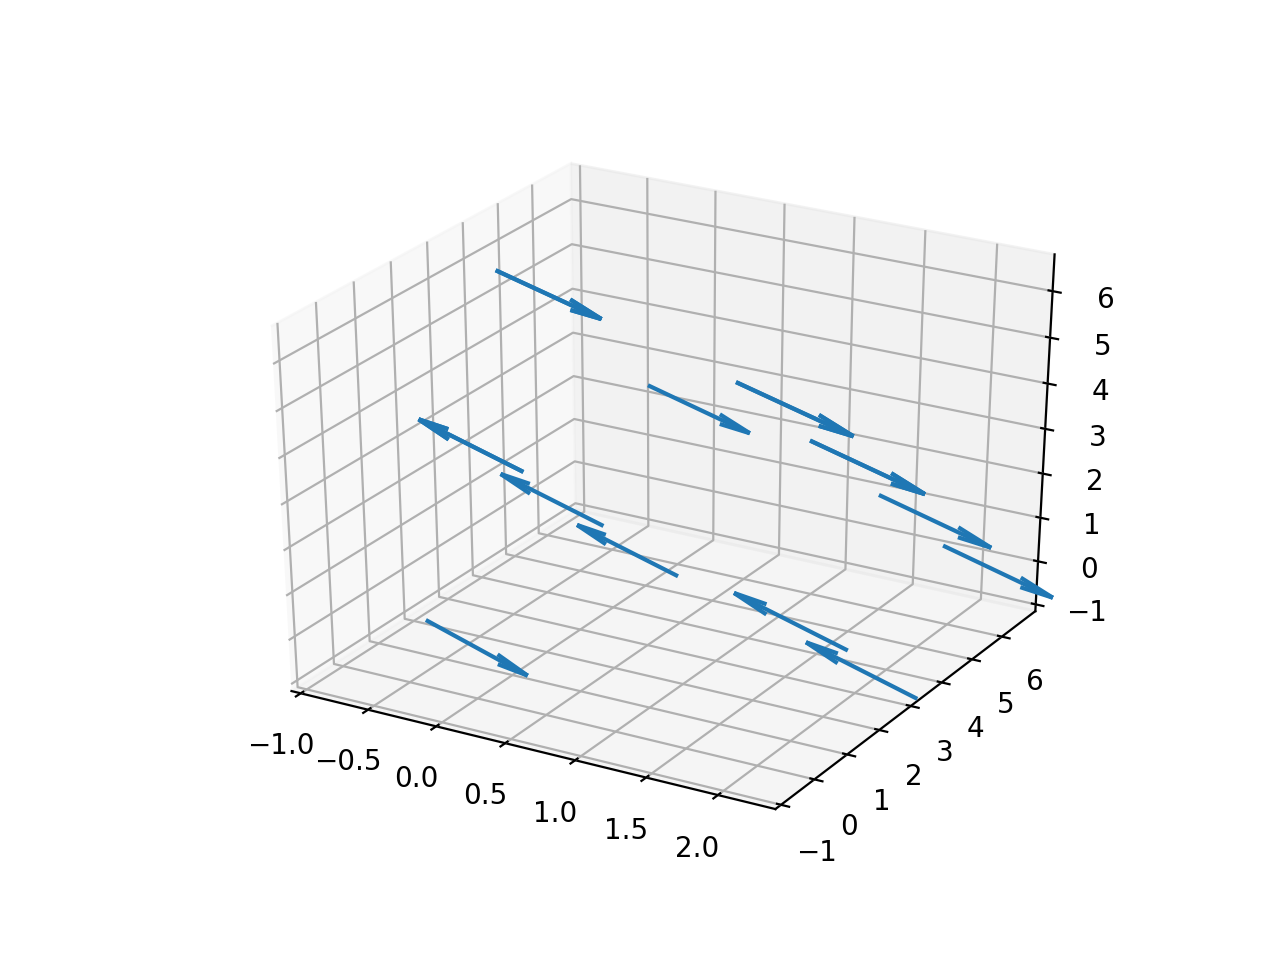

In [3]:
### Load in the refined atomic structure
struc = loadStructure('MnO_struc.stru')

### Create a magnetic species object (assuming a given propagation vector and basis vectors)
msp = MagSpecies(struc,magIdxs=[0,1,2,3],ffparamkey='Mn2',rmaxAtoms=50,
                basisvecs=np.array([1,-1,0]),kvecs=np.array([0.5,0.5,0.5]),label='Mn2+')

### Create a magnetic structure object and load in the Mn2+ magnetic species
mstr=MagStructure()
mstr.loadSpecies(msp)

### Generate the spin positions and orientations
mstr.makeAll()

### Visualize the magnetic structure
uc = struc[:4].xyz
visatoms = uc.copy()
visatoms = np.concatenate((visatoms,visatoms+np.array([0,0,1]),visatoms+np.array([0,1,0]),visatoms+np.array([0,0,1])))
visatoms = struc.lattice.cartesian(visatoms)
visspins = mstr.spinsFromAtoms(visatoms,fractional=False)
mstr.visualize(visatoms,visspins);

### Create the mPDF calculator object

<IPython.core.display.Javascript object>


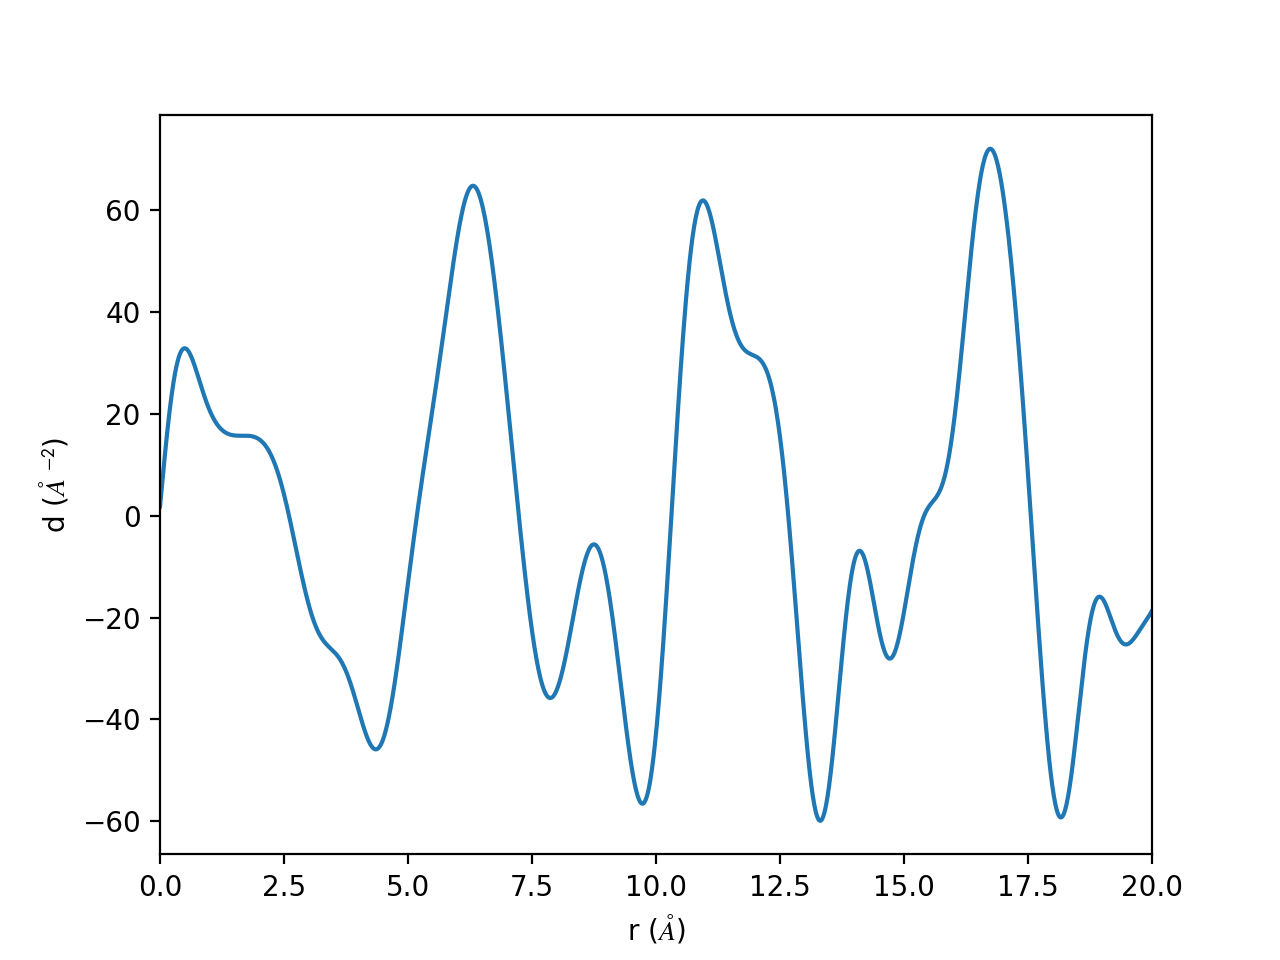

In [4]:
mc = MPDFcalculator(mstr)

### Quick check of the calculated mPDF
mc.plot(normalized=False);

### Set up the fit in SrFit (just like an atomic PDF fit)

In [5]:
### Set the atomic PDF fit residual as our fit profile
from diffpy.srfit.fitbase import Profile
profile = Profile()
profile.setObservedProfile(r, Gdiff)

### set the MPDFcalculator grid to match the data
mc.rmin = r.min()
mc.rmax = r.max()
mc.rstep = r[1] - r[0]

### Make the FitContribution
from diffpy.srfit.fitbase import FitContribution
mfit = FitContribution('mfit')
mfit.setProfile(profile)

### Define the function that will calculate the mPDF
def mpdf(ordscale, parascale, damp):
    '''
    ordscale: overall scale factor for the mPDF; related to magnitude
              of the ordered magnetic moment.
    parascale: scale factor related to the magnetic form factor;
               contains no structural information.
    damp: real-space damping term; equivalent to Qdamp
    '''
    mc.ordScale, mc.paraScale, mc.dampRate = ordscale, parascale, damp
    
    ### calculate and return the unnormalized mPDF
    mcalc = mc.calc(both=True)[2]
    return mcalc

mfit.registerFunction(mpdf)
mfit.setEquation("mpdf(ordscale, parascale, damp)")

### Make the FitRecipe and add the relevant variables
from diffpy.srfit.fitbase import FitRecipe
recipe = FitRecipe()

### Give the PDFContribution to the FitRecipe
recipe.addContribution(mfit)

### Add the mPDF variables
recipe.addVar(mfit.parascale, 4)
recipe.addVar(mfit.ordscale, 0.5)
recipe.addVar(mfit.damp, 0.01);

### Run the refinement

Final values: [2.89595658 1.23062248 0.00673758]


<IPython.core.display.Javascript object>


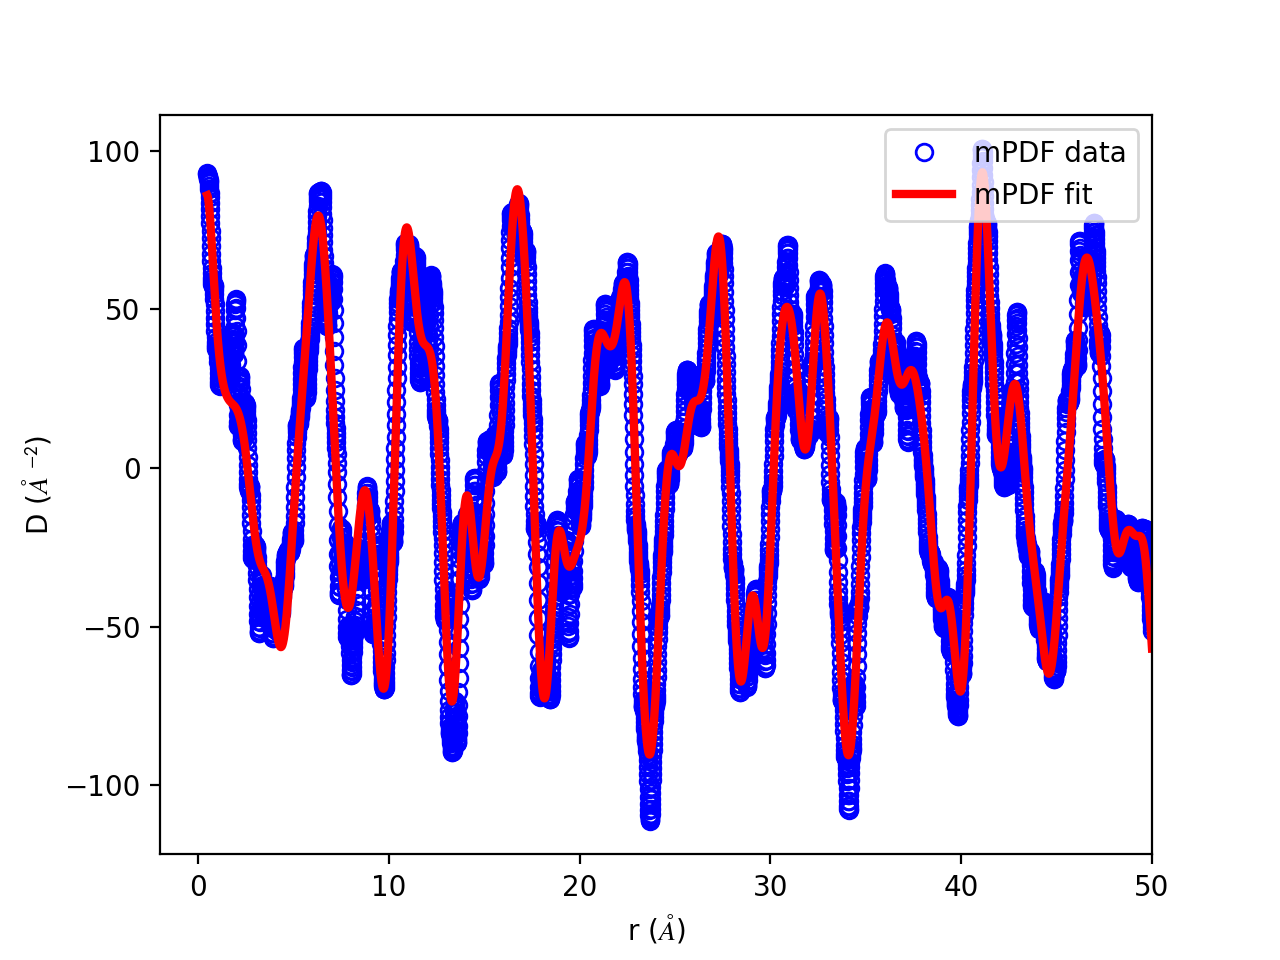

In [6]:
### Run the refinement
from scipy.optimize import least_squares

# Turn off printout of iteration number.
recipe.clearFitHooks()

least_squares(recipe.residual, recipe.values)
print("Final values:", recipe.values)

### Plot the results
fit = mfit.evaluateEquation("mpdf")

ax=plt.figure().add_subplot(111)
ax.plot(r, Gdiff, 'bo', label="mPDF data", markerfacecolor='none', markeredgecolor='b')
ax.plot(r, fit, 'r-', lw=3, label="mPDF fit")
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"D ($\AA^{-2}$)")
ax.set_xlim(xmax=mc.rmax)
plt.legend(loc=1);

<IPython.core.display.Javascript object>


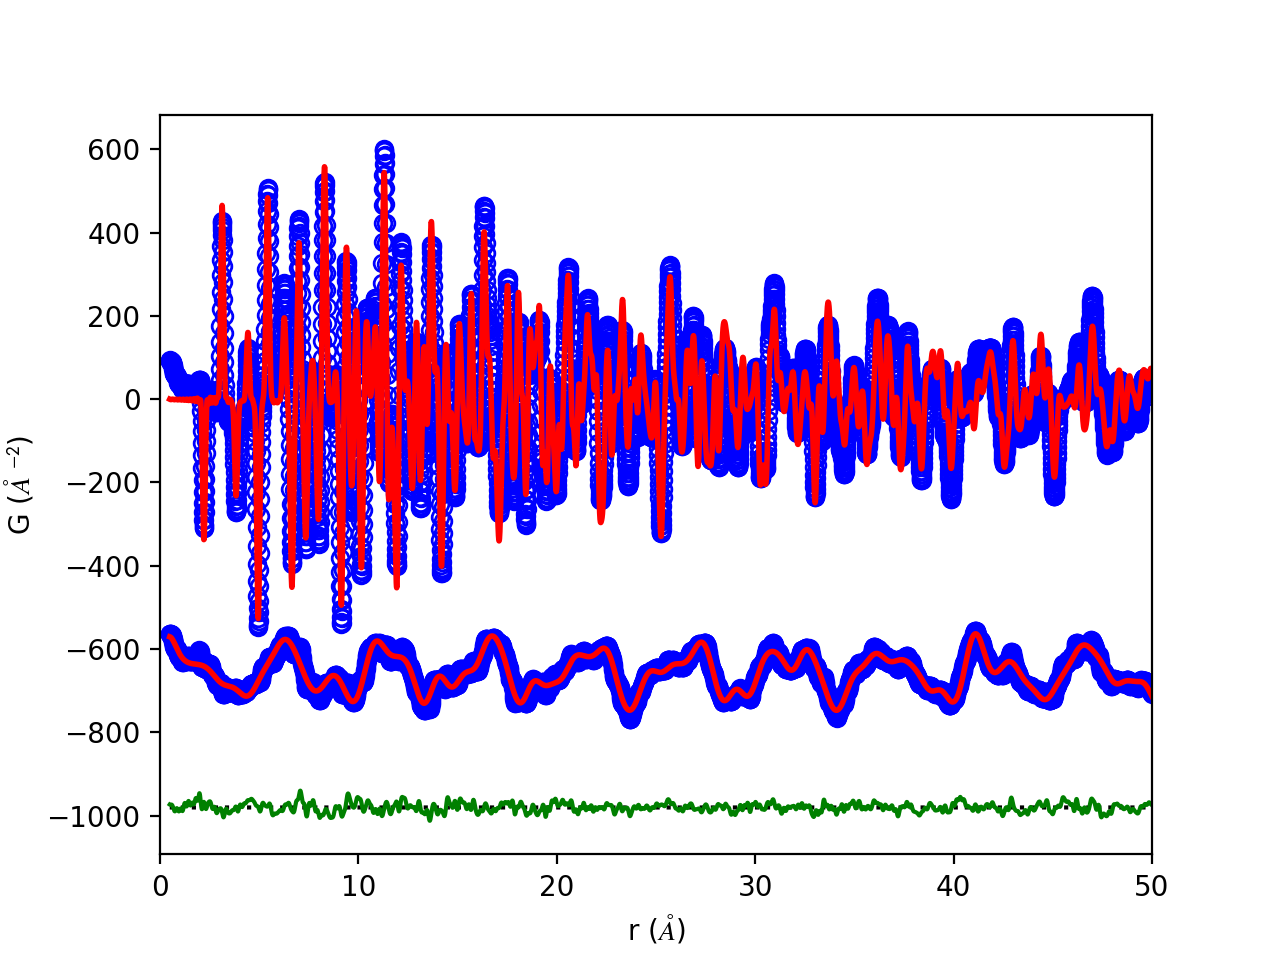

In [7]:
### Plot the total PDF (atomic + magnetic) with the total fit
offset1 = 1.2*G.min()
offset2 = offset1 - 8*(Gdiff - fit).max()

# Make the figure.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(r,G,marker='o',mfc='none',mec='b',linestyle='none') ### total observed PDF pattern 
ax.plot(r,Gcalc,'r-',lw=2) ### calculated atomic PDF
ax.plot(r,Gdiff+offset1,marker='o',mfc='none',mec='b',linestyle='none') ### residual from atomic PDF fit
ax.plot(r,fit+offset1,'r-',lw=2) ### calculated mPDF
ax.plot(r,np.zeros_like(r)+offset2,'k:')
ax.plot(r,Gdiff - fit + offset2,'g-') ### overall fit residual after including atomic and magnetic PDFs
ax.set_xlim(xmin=0,xmax=mc.rmax)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('G ($\AA^{-2}$)');

### Determine the magnitude of the ordered moment from the fit

If we call $A$ the nuclear scale factor, $B$ the mPDF ordered scale factor, $n_s$ the fraction of atoms in the system that are magnetic, and $\langle b \rangle$ the average nuclear scattering length, then the magnitude of the refined moment $\mathrm{S_{fit}}$ is related to the nominal magnitude of the spin vectors $\mathrm{S_{nom}}$ used in the magnetic structure through the equation $\mathrm{S_{fit}} = \sqrt{\frac{\mathrm{B}\langle b \rangle ^2}{\mathrm{A} n_s}} \mathrm{S_{nom}}$. When multiplied by the g factor (e.g. 2 for pure spins without any orbital contributions to the moment), this gives the ordered moment in Bohr magnetons.

In [8]:
nucScale = 0.9518 ### refined nuclear scale factor taken from PDFgui

### Calculate the average nuclear scattering length
import periodictable as pt ### useful python package included in your installation of diffpy.mpdf
bMn = pt.Mn.neutron.b_c
bO = pt.O.neutron.b_c
bAvg = 0.5*bMn+0.5*bO

### define the ratio of magnetic atoms to total atoms in MnO
ns = 0.5

### determine the nominal spin magnitude from your structure
Snom = np.linalg.norm(mstr.spins[0])

### calculate the refined value of the ordered moment
Sfit = 2*np.sqrt(mc.ordScale*bAvg**2/(nucScale*ns))*Snom
print("Sfit =", Sfit)

Sfit = 4.673383200561141


#### This is in line with expectations for the S = 5/2 moment in MnO.